# Фаза 2. Неделя 11
## Рекомендательные системы
### Базовый нейросетевой подход 

In [1]:
# !wget -P https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -qq aux/ml-100k.zip

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torchutils as tu

# from surprise import
from sklearn.model_selection import train_test_split

torch.manual_seed(666)
import os
import time
import mlflow
import multiprocessing as mp


# эта строка закомментирована, потому что эти
# функции вам предстоит реализовать в сегодняшнем задании
from aux.recommend import *
from aux.dataset_class import MovieLensDataset

In [4]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CURR_DIR = os.path.dirname("__name__")
CURR_DIR

''

In [5]:
col_names = ["user_id", "item_id", "rating", "timestamp"]
train_df = pd.read_csv("data/u1.base", sep="\t", header=None, names=col_names)
valid_df = pd.read_csv("data/u1.test", sep="\t", header=None, names=col_names)

In [6]:
movie_id = pd.read_csv("data/u.item", sep="|", encoding="iso-8859-1", header=None).iloc[
    :, 0:2
]
movie_id.columns = ["id", "title"]
movie_id["id"] = movie_id["id"]
id_to_movie = dict(zip(movie_id["id"], movie_id["title"]))

In [7]:
train_df[["user_id", "item_id"]] = train_df[["user_id", "item_id"]]
valid_df[["user_id", "item_id"]] = valid_df[["user_id", "item_id"]]

In [8]:
train_df

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [9]:
train_df["user_id"].nunique()

943

In [10]:
# Эти данные нужны для эмбеддинг слоев
UNIQUE_USERS = train_df["user_id"].nunique() + 1  # Для слоя Embedding
UNIQUE_MOVIES = len(id_to_movie.items()) + 1  # Для слоя Embedding
print(f"Unique users: {UNIQUE_USERS}, unique movies: {UNIQUE_MOVIES}")

Unique users: 944, unique movies: 1683


In [11]:
display(train_df)
display(valid_df)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [12]:
# class MovieLensDataset(Dataset):
#     def __init__(
#         self,
#         df: pd.DataFrame,
#         user_col: int = 0,
#         item_col: int = 1,
#         rating_col: int = 2,
#     ):

#         self.df = df

#         self.user_tensor = torch.tensor(
#             self.df.iloc[:, user_col].to_numpy(), dtype=torch.long, device=DEVICE
#         )
#         self.item_tensor = torch.tensor(
#             self.df.iloc[:, item_col].to_numpy(), dtype=torch.long, device=DEVICE
#         )
#         self.trgt_tensor = torch.tensor(
#             self.df.iloc[:, rating_col].to_numpy(), dtype=torch.float32, device=DEVICE
#         )

#     def __len__(self):
#         return self.user_tensor.shape[0]
#         # return len(self.df)

#     def __getitem__(self, index):
#         return (
#             self.user_tensor[index],
#             self.item_tensor[index],
#             self.trgt_tensor[index],
#         )


BATCH_SIZE = 128
train_dataset = MovieLensDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = MovieLensDataset(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class BaseRecNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        # параметры сети
        self.config = config
        self.num_users = config["num_users"]
        self.num_items = config["num_items"]
        self.emb_size = config["emb_size"]
        self.emb_droupout = config["emb_drop"]
        self.dropout = config["lin_drop"]
        self.out_range = config["out_range"]

        # embedding-слои
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout),
        )
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout),
        )

        self.lin_user = nn.Linear(self.emb_size, self.emb_size)
        self.lin_item = nn.Linear(self.emb_size, self.emb_size)

        # финальный полносвязный слой для пронгоза оценки
        self.head = nn.Sequential(
            nn.Linear(self.emb_size * 2, 512),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, user_idx, item_idx):
        user_emb = F.sigmoid(self.lin_user(self.emb_user(user_idx)))
        item_emb = F.sigmoid(self.lin_item(self.emb_item(item_idx)))
        x = torch.cat([user_emb, item_emb], dim=1)
        # print(x)
        x = torch.sigmoid(self.head(x))  # [0, 1]
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        # x = 1 -> 1 * (5 - 1) + 1 = 5
        # x = 0.1 -> .1 * 4 + 1 = 1.4.int() -> 1
        return x


config = {
    "num_users": UNIQUE_USERS,  # число уникальных пользователей
    "num_items": UNIQUE_MOVIES,  # число уникальных филмьов
    "emb_size": 16,  # размер эмбеддинга
    "emb_drop": 0.05,  # параметр для слоя эмбеддинга
    "lin_drop": 0.5,  # dropout head layer
    "out_range": [1.0, 5.0],  # для нормировки выходных оценок
}
model = BaseRecNet(config)

In [14]:
# посмотрим, что нам возвращает data loader
# test_batch = next(iter(train_loader))
# print(
#     f"""test_batch content:
# [user_id, user_id, ...]   -> {test_batch[0]}
# [movie_id, movie_id, ...] -> {test_batch[1]}
# [rating, rating, ...]     -> {test_batch[2]}
# """
# )

# # отправим в модель и посмотрим на выход
# model.to(DEVICE)(test_batch[0].to(DEVICE), test_batch[1].to(DEVICE))[:10]

In [15]:
# tu.get_model_summary(model, user_idx=test_batch[0], item_idx=test_batch[1])

In [16]:
criterion = lambda preds, target: F.smooth_l1_loss(preds, target, beta=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
history = {"epoch_train_losses": [], "epoch_valid_losses": []}

In [18]:
def fit_model(n_epochs: int = 10, history: dict = history, model=model) -> dict:

    history = history or {"epoch_train_losses": [], "epoch_valid_losses": []}

    for i in tqdm(range(n_epochs)):
        batch_losses = []
        model.train()
        for user, item, rating in train_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        history["epoch_train_losses"].append(np.mean(batch_losses))

        model.eval()

        batch_losses = []
        for user, item, rating in valid_loader:
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            batch_losses.append(loss.item())

        history["epoch_valid_losses"].append(np.mean(batch_losses))
    return history

In [19]:
# %%time
# log = fit_model(50, history)
# plt.plot(history['epoch_train_losses'])
# plt.plot(history['epoch_valid_losses'])

### Задание 1


Создай файл `recommend.py` в папке `aux` и реализуй в нем 2 функции: 
   
1. __recommend_for_user_id_from_valid__

    Функция принимает на вход идентификатор пользователя, делает по нему выборку из валидационной части, 
    затем прогнозирует рейтинги для тех фильмов, которым пользователь поставил оценку. 
    Результат работы функции – датафрейм: 

    | movie_id | title | pred_rating | true_rating | 
    |----------|-------|-------------|-------------|


    ```python
    (function) def recommend_for_user_id_from_valid

    Returns dataframe top n movies, true and pred ratings 

        Args:
            user_id (int): user_id for predictions
            valid_df (pd.DataFrame): valid dataframe
            model (torch.nn.Module): neural net
            n (int, optional): top_n movies will be returned. Defaults to 10..

        Returns:
            pd.DataFrame: with 4 cols: movie_id, title, pred_rating, true_rating
            shape(n, 4)
        
    ```



In [20]:
display(valid_df)

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [21]:
recs = recommend_for_user_id_from_valid(100, valid_df, model, DEVICE, id_to_movie, -1)
recs

,movie_id,title,pred_rating,rating
5041,268,Chasing Amy (1997),2.956048,3
5043,289,Evita (1996),2.955639,3
5042,288,Scream (1996),2.945518,2
5061,905,Great Expectations (1998),2.937534,3
5050,333,"Game, The (1997)",2.926019,3
5046,313,Titanic (1997),2.925988,5
5045,302,L.A. Confidential (1997),2.921194,4
5040,266,Kull the Conqueror (1997),2.913097,2
5058,691,Dark City (1998),2.912787,4
5049,323,Dante's Peak (1997),2.911422,3


2. __recommend_for_user_id_unwatched__


    ```python
    (function) recommend_for_user_id_unwatched

    Return DataFrame with sorted by pred_rating among unwatched films

        Args:
            user_id (int): user_id for recommedations 
            full_df (pd.DataFrame): full dataframe
            id_to_movie (dict): dict with id and corresponding movie title

        Returns:
            pd.DataFrame: shape (n_unwatched_movies, 2) with predicted rating and movie title
    ```

In [22]:
full_df = pd.concat([train_df, valid_df], axis=0)
display(full_df.head())
display(full_df.shape)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


(100000, 4)

In [23]:
# tempdf = pd.DataFrame(id_to_movie)
# tempdf

In [24]:
# recommend_unwatched, num_watched, num_unwatched = recommend_for_user_id_unwatched(
#     user_id=37,
#     full_df=pd.concat([train_df, valid_df], axis=0),
#     id_to_movie=id_to_movie,
#     model=model,
#     device=DEVICE,
#     n=10,
# )
# display(recommend_unwatched)
# print(num_watched, num_unwatched)

Сохрани файл на `github`

### Задание 2

Реализуй функции для вычисления метрики **precision@k** и **recall@k**. 
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 

In [25]:
def precision_k(actual_ratings, pred_ratings, k: int, y=3.5) -> float:
    if k == 0:
        return 0
    df = pd.DataFrame({"actual": actual_ratings, "predicted": pred_ratings})
    df = df.sort_values("predicted", ascending=False)
    top_k = df.iloc[:k, :]
    n_recommended = top_k[top_k["predicted"] >= y].shape[0]
    n_relevant_and_recommended = top_k[
        (top_k["predicted"] >= y) & (top_k["actual"] >= y)
    ].shape[0]
    precision = n_relevant_and_recommended / n_recommended if n_recommended != 0 else 0
    return precision


def recall_k(actual_ratings, pred_ratings, k: int, y=3.5) -> float:
    if k == 0:
        return 0
    df = pd.DataFrame({"actual": actual_ratings, "predicted": pred_ratings})
    df = df.sort_values("predicted", ascending=False)
    top_k = df.iloc[:k, :]
    n_relevant = top_k[top_k["actual"] >= y].shape[0]
    n_relevant_and_recommended = top_k[
        (top_k["predicted"] >= y) & (top_k["actual"] >= y)
    ].shape[0]
    recall = n_relevant_and_recommended / n_relevant if n_relevant != 0 else 0
    return recall

### Задание 3 

Вычисли средний precision и recall для всех пользователей: присутствующих в обучающей и валидационных выборках.

In [26]:
display(valid_df)
display(train_df)

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [65]:
def compute_total_metrics(val_df: pd.DataFrame, model, device, id_to_movie: dict):
    user_ids = val_df["user_id"].unique().tolist()
    precisions = []
    recalls = []
    for c in user_ids:
        user_df = recommend_for_user_id_from_valid(
            user_id=c,
            valid_df=val_df,
            model=model,
            device=device,
            id_to_movie=id_to_movie,
            n=-1,
        )
        precisions.append(
            precision_k(user_df["rating"], user_df["pred_rating"], k=user_df.shape[0])
        )
        recalls.append(
            recall_k(user_df["rating"], user_df["pred_rating"], k=user_df.shape[0])
        )
    total_precision = np.mean(precisions)
    total_recall = np.mean(recalls)
    return total_precision, total_recall

In [66]:
prec_t, rec_t = compute_total_metrics(
    train_df, model=model, device="cpu", id_to_movie=id_to_movie
)
prec_v, rec_v = compute_total_metrics(
    valid_df, model=model, device="cpu", id_to_movie=id_to_movie
)
print(f"Train dataset: Precision = {prec_t:.3f} Recall={rec_t:.3f}")
print(f"Valid dataset: Precision = {prec_v:.3f} Recall={rec_v:.3f}")

Train dataset: Precision = 0.000 Recall=0.000
Valid dataset: Precision = 0.000 Recall=0.000


### Задание 4

Используй увеличенную версию датасета: обучи модель, сравни метрики с получившимися выше. 

```
!wget -O data/ml25.zip --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -qq data/ml25.zip
```

In [ ]:
# !wget -O data/ml25.zip --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip
# !unzip -qq data/ml25.zip

In [30]:
DATASET_DIR = os.path.join(CURR_DIR, "data", "ml-25m")
ratings_big = pd.read_csv(os.path.join(DATASET_DIR, "ratings.csv"))
movies_big = pd.read_csv(os.path.join(DATASET_DIR, "movies.csv"))
ratings_big.rename(columns={"userId": "user_id", "movieId": "movie_id"}, inplace=True)
ratings_big.drop("timestamp", inplace=True, axis=1)
movies_big.rename(columns={"movieId": "movie_id"}, inplace=True)
movies_big.drop("genres", inplace=True, axis=1)

In [31]:
print(ratings_big.shape)
display(ratings_big.head(3))
print(movies_big.shape)
display(movies_big.head(3))

(25000095, 3)


,user_id,movie_id,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0


(62423, 2)


,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)


In [32]:
movies_big.reset_index(inplace=True)
movies_big["new_id"] = movies_big["index"] + 1
movies_big.drop("index", inplace=True, axis=1)
old_new_id = dict(zip(movies_big["movie_id"], movies_big["new_id"]))
movies_big.rename(columns={"movie_id": "old_id", "new_id": "movie_id"}, inplace=True)
display(movies_big.head())
# display(movies_big[movies_big["movie_id"] != movies_big["new_id"]])

,old_id,title,movie_id
0,1,Toy Story (1995),1
1,2,Jumanji (1995),2
2,3,Grumpier Old Men (1995),3
3,4,Waiting to Exhale (1995),4
4,5,Father of the Bride Part II (1995),5


In [33]:
ratings_big["movie_id"] = ratings_big["movie_id"].apply(lambda x: old_new_id[x])

In [34]:
ratings_big["movie_id"].max()

62423

In [35]:
movies_big["movie_id"].nunique()

62423

In [36]:
movies_big["movie_id"].max()

62423

In [37]:
id_to_movie_big = dict(zip(movies_big["movie_id"], movies_big["title"]))

In [38]:
users = ratings_big["user_id"].unique().tolist()

In [39]:
dataset = MovieLensDataset(ratings_big)

In [40]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_ds_big, valid_ds_big = random_split(dataset, [train_size, valid_size])

In [41]:
# train_ds, valid_ds = train_test_split(dataset, test_size=0.2, random_state=42)

In [42]:
train_idxs = train_ds_big.indices
train_user_ids = ratings_big.loc[train_idxs, ["user_id"]]
train_user_ids.max()

user_id    162541
dtype: int64

In [43]:
len(users)

162541

In [44]:
train_movie_ids = ratings_big.loc[train_idxs, ["movie_id"]]
train_movie_ids.nunique()

movie_id    56648
dtype: int64

In [45]:
len(id_to_movie_big.items())

62423

In [46]:
max(id_to_movie_big.keys())

62423

In [63]:
UNIQUE_USERS_BIG = max(users) + 1  # Для слоя Embedding
UNIQUE_MOVIES_BIG = max(id_to_movie_big.keys()) + 1  # Для слоя Embedding

In [64]:
print(f"Unique users: {UNIQUE_USERS_BIG}, unique movies: {UNIQUE_MOVIES_BIG}")

Unique users: 162542, unique movies: 62424


In [62]:
print(ratings_big["user_id"].nunique())
print(ratings_big["movie_id"].nunique())
print(ratings_big["user_id"].max())
print(ratings_big["movie_id"].max())

162541
59047
162541
62423


In [50]:
ratings_big["movie_id"].max()

62423

In [51]:
config_big = {
    "num_users": UNIQUE_USERS_BIG,  # число уникальных пользователей
    "num_items": UNIQUE_MOVIES_BIG,  # число уникальных филмьов
    "emb_size": 16,  # размер эмбеддинга
    "emb_drop": 0.05,  # параметр для слоя эмбеддинга
    "lin_drop": 0.5,  # dropout head layer
    "out_range": [1.0, 5.0],  # для нормировки выходных оценок
}

In [52]:
model_big = BaseRecNet(config_big)
model_big.to(DEVICE)

BaseRecNet(
  (emb_user): Sequential(
    (0): Embedding(162542, 16)
    (1): Dropout(p=0.05, inplace=False)
  )
  (emb_item): Sequential(
    (0): Embedding(62424, 16)
    (1): Dropout(p=0.05, inplace=False)
  )
  (lin_user): Linear(in_features=16, out_features=16, bias=True)
  (lin_item): Linear(in_features=16, out_features=16, bias=True)
  (head): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [53]:
criterion_big = lambda preds, target: F.smooth_l1_loss(preds, target, beta=0.5)
optimizer_big = optim.Adam(model_big.parameters(), lr=1e-4)

In [54]:
BATCH_SIZE_BIG = 512
train_loader_big = DataLoader(
    train_ds_big,
    batch_size=BATCH_SIZE_BIG,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
valid_loader_big = DataLoader(
    valid_ds_big,
    batch_size=BATCH_SIZE_BIG,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [55]:
# history_big = {"epoch_train_losses": [], "epoch_valid_losses": []}

In [56]:
def fit_model_big(
    n_epochs: int = 10,
    model=model_big,
    train_loader=train_loader_big,
    valid_loader=valid_loader_big,
) -> dict:

    history = {"epoch_train_losses": [], "epoch_valid_losses": []}

    start_epoch = len(history["epoch_train_losses"])
    for epoch in range(start_epoch + 1, start_epoch + n_epochs + 1):
        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch}/{n_epochs} [Train]", leave=True
        )

        batch_losses = []
        model.train()
        for user, item, rating in train_pbar:
            user = user.to(DEVICE)
            item = item.to(DEVICE)
            rating = rating.to(DEVICE)
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        history["epoch_train_losses"].append(np.mean(batch_losses))
        train_pbar.set_postfix(
            {
                "Loss": loss,
            }
        )

        model.eval()
        valid_pbar = tqdm(
            valid_loader, desc=f"Epoch {epoch}/{n_epochs} [Test]", leave=True
        )
        batch_losses = []
        for user, item, rating in valid_pbar:
            user = user.to(DEVICE)
            item = item.to(DEVICE)
            rating = rating.to(DEVICE)
            preds = model(user, item)
            loss = criterion(preds.squeeze(-1), rating)
            batch_losses.append(loss.item())

        history["epoch_valid_losses"].append(np.mean(batch_losses))
        valid_pbar.set_postfix(
            {
                "Loss": loss,
            }
        )
        print(f"Train stage: " f"loss: {history['epoch_train_losses'][-1]:>6.3f}  ")

        # Valid stage
        print(f"Valid stage: " f"loss: {history['epoch_valid_losses'][-1]:>6.3f}  ")
    return history

Epoch 1/3 [Train]:   0%|          | 0/39063 [00:00<?, ?it/s]

Epoch 1/3 [Test]: 100%|██████████| 9766/9766 [00:25<00:00, 380.64it/s]


Train stage: loss:  0.791  
Valid stage: loss:  0.786  


Epoch 2/3 [Test]: 100%|██████████| 9766/9766 [00:24<00:00, 405.38it/s]


Train stage: loss:  0.791  
Valid stage: loss:  0.786  


Epoch 3/3 [Test]: 100%|██████████| 9766/9766 [00:23<00:00, 420.82it/s]

Train stage: loss:  0.791  
Valid stage: loss:  0.786  
CPU times: user 4min 55s, sys: 53 s, total: 5min 48s
Wall time: 6min 20s


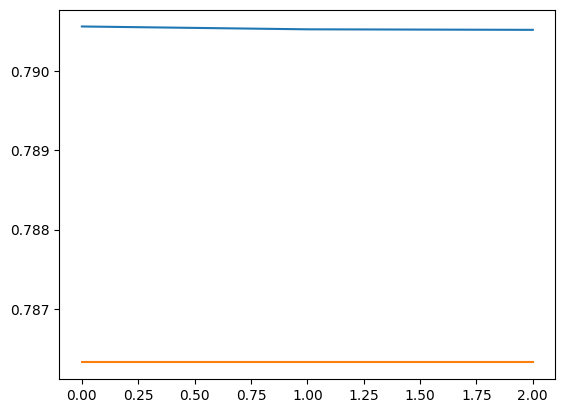

In [57]:
%%time
log_big = fit_model_big(3, model=model_big)
plt.plot(log_big['epoch_train_losses'])
plt.plot(log_big['epoch_valid_losses'])

In [ ]:
# torch.save(model_big.state_dict(), "weights/big_model_3_epochs.pth")

In [59]:
train_idxs = list(train_ds_big.indices)
valid_idxs = list(valid_ds_big.indices)
train_df_big = ratings_big.loc[train_idxs, :]
valid_df_big = ratings_big.loc[valid_idxs, :]
train_df_big.rename(columns={"movie_id": "item_id"}, inplace=True)
valid_df_big.rename(columns={"movie_id": "item_id"}, inplace=True)

In [68]:
prec_t_big, rec_t_big = compute_total_metrics(
    train_df_big, model=model_big, device="cpu", id_to_movie=id_to_movie_big
)
prec_v_big, rec_v_big = compute_total_metrics(
    valid_df_big, model=model_big, device="cpu", id_to_movie=id_to_movie_big
)
print(f"Train dataset: Precision = {prec_t:.3f} Recall={rec_t:.3f}")
print(f"Valid dataset: Precision = {prec_v:.3f} Recall={rec_v:.3f}")

KeyboardInterrupt: 